# Data Aggregation

## Importing Essential Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import geopy.distance
import math

## Loading Data

In [74]:
maize_data_path = "../data/raw/yield_maize.tif"
soybean_data_path = "../data/raw/yield_soybean.tif"
defor_img_path = "../data/raw/10S60W.tif"

# Loading maize data
with rio.open(maize_data_path) as maize_src:
    maize_data = maize_src.read()
maize_data = np.squeeze(maize_data)

# Loading deforestation data
with rio.open(defor_img_path) as defor_src:
    defor_data = defor_src.read()
defor_data = np.squeeze(defor_data)

## Defining Data Segmentation Functions

In [89]:
def get_lat_long(data, src):
    # index array
    lat_index = np.arange(0, data.shape[0])
    long_index = np.arange(0, data.shape[1])
    
    # meshgrid
    long_grid, lat_grid = np.meshgrid(long_index, lat_index)
    
    # flattened grids
    lat_grid_flat = lat_grid.flatten()
    long_grid_flat = long_grid.flatten()
    
    # getting long and lat
    A = src.transform
    long, lat = rio.transform.xy(A, lat_grid_flat, long_grid_flat)
    
    # reshaping to shape of original data
    lat = np.array(lat).reshape(data.shape)
    long = np.array(long).reshape(data.shape)
    
    return lat, long

def segment_coords(data, lat, long, target_coords = (0, 0), length = 10):
    # latitude/longitude variables
    lat_max = target_coords[0]
    lat_min = lat_max - length
    long_min = target_coords[1]
    long_max = long_min + length
    
    # length variables
    xlen = data.shape[1]
    ylen = data.shape[0]
    
    # find xmin and xmax
    xmin, xmax = None, None
    for x in range(xlen):
        if long[0, x] > long_min:
            xmin = x if xmin == None else xmin
        if long[0, xlen - x - 1] < long_max:
            xmax = xlen - x - 1 if xmax == None else xmax
            
    # find ymin and ymax
    ymin, ymax = None, None
    for y in range(ylen):
        if lat[ylen - y - 1, 0] > lat_min:
            ymin = ylen - y - 1 if ymin == None else ymin
        if lat[y, 0] < lat_max:
            ymax = y if ymax == None else ymax
            
    # index data from top-bottom, left-right
    return data[ymax:ymin, xmin:xmax]

## Segmenting Maize Data

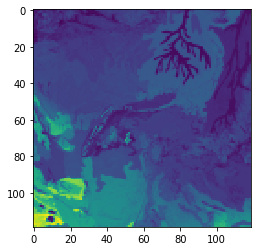

In [90]:
# Segmenting Maize Data 10S60W
target_coords = (-10, -60)
lat, long = get_lat_long(maize_data, maize_src)

maize_data_seg = segment_coords(maize_data, lat, long, target_coords, length = 10) 
plt.imshow(maize_data_seg)

## Defining Spatial Resolution Functions

In [91]:
def get_dist(coords_1, coords_2):
    return geopy.distance.distance(coords_1, coords_2).km

def get_spatial_res(dist, arr):
    return (dist / arr.shape[0])

## Compute Spatial Resolution

In [101]:
dist = get_dist((-10, -60), (-10, -50))

defor_spatial_res = get_spatial_res(dist, defor_data)
print("Defor Spatial Resolution: {} km".format(defor_spatial_res))

maize_spatial_res = get_spatial_res(dist, maize_data_seg)
print("Maize Spatial Resolution: {} km".format(maize_spatial_res))

Defor Spatial Resolution: 0.027408788864225136 km
Maize Spatial Resolution: 9.213038273689122 km


In [93]:
# 10 South, 60 West
print("Top Border Distance: {} km".format(get_dist((-10, -60), (-10, -50))))
print("Right Border Distance: {} km".format(get_dist((-10, -50), (-20, -50))))
print("Bot Border Distance: {} km".format(get_dist((-20, -60), (-20, -50))))
print("Left Border Distance: {} km".format(get_dist((-20, -60), (-10, -60))))

Top Border Distance: 1096.3515545690054 km
Right Border Distance: 1106.511420937261 km
Bot Border Distance: 1046.3150761044421 km
Left Border Distance: 1106.511420937261 km


## Computing 3km Grid

In [109]:
'''
Generates a grid where each cell represents the sum of a arr_spatial_res by cell_num_meter chunk of data.
Returns a tuple of sum grid, arr_spatial_res.
'''
def data_to_grid(arr, arr_spatial_res, grid_spatial_res = 3):
    # Initialize grid
    GRID_SIZE = math.ceil((arr.shape[0] * arr_spatial_res) / grid_spatial_res) + 1
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    # Generate grid
    for y in range(0, arr.shape[0]):
        for x in range(0, arr.shape[1]):
            # getting distance (in km) of top left corner of pixel from top left corner of entire data
            y_dist = y * arr_spatial_res
            x_dist = x * arr_spatial_res
            
            # getting indexes of grid
            grid_y = math.floor(y_dist / grid_spatial_res)
            grid_x = math.floor(x_dist / grid_spatial_res)
            
            # getting indexes of grid
            grid_y_dist = y // grid_spatial_res
            grid_x_dist = x // grid_spatial_res
            
            height_in, width_in, height_out, width_out = 0.0, 0.0, 0.0, 0.0
            
            if arr_spatial_res > grid_spatial_res:
                # compute height and width (in km) inside of grid
                height_in =  y_dist + arr_spatial_res - grid_y_dist + grid_spatial_res
                width_in =  x_dist + arr_spatial_res - grid_x_dist + grid_spatial_res
                
                # compute height and width (in km) outside of grid
                height_out = grid_spatial_res - height_in
                width_out = grid_spatial_res - width_in
            else:
                # compute height and width (in km) inside of grid
                height_in = grid_y_dist + grid_spatial_res - y_dist + arr_spatial_res
                width_in = grid_x_dist + grid_spatial_res - x_dist + arr_spatial_res
                
                # compute height and width (in km) outside of grid
                height_out = arr_spatial_res - height_in
                width_out = arr_spatial_res - width_in
                
            # update grid values
            grid[grid_y, grid_x] += width_in * height_in * arr[y, x]
            grid[grid_y + 1, grid_x] += width_in * height_out * arr[y, x]
            grid[grid_y, grid_x + 1] += width_out * height_in * arr[y, x]
            grid[grid_y + 1, grid_x + 1] += width_out * height_out * arr[y, x]
    return grid

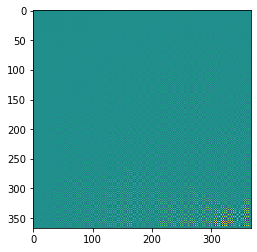

In [111]:
grid = data_to_grid(maize_data_seg, maize_spatial_res)
plt.imshow(grid)

In [103]:
data_to_grid(defor_data, defor_spatial_res)

1096.3515545690054
367


KeyboardInterrupt: 